In [2]:
import csv
import gzip
import time
import numpy
import random
import operator
from scipy import stats
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
reader = csv.reader(open('../data/all_relationships_plink_maskedids.txt'), delimiter='\t')
reader.next()

rels = defaultdict(dict)
rel2dna = dict()
individuals = set()

for wid1, wid2, relationship, pihat, pred in reader:
    relationship = relationship.strip()
    if wid1 < wid2:
        id1 = wid1
        id2 = wid2
    else:
        id1 = wid2
        id2 = wid1
    individuals.add(wid1)
    individuals.add(wid2)
    rels[relationship][(id1, id2)] = (float(pred), float(pihat))
    rel2dna[relationship] = float(pred)
rels = dict(rels)
for rel in rel2dna.keys():
    print rel, rel2dna[rel], len(rels[rel])

len(individuals)

Aunt/Uncle 0.25 6
Grandnephew/Grandniece 0.0625 1
Grandaunt/Granduncle 0.0625 1
Parent 0.5 77
Sibling 0.5 19
Grandchild 0.25 3
Child 0.5 78
Grandparent 0.25 3
Nephew/Niece 0.25 6


186

In [5]:
preds = list()
sims = list()
for rel in ('Nephew/Niece', 'Grandnephew/Grandniece', 'Child', 'Sibling', 'Grandchild'):
    for (id1, id2) in rels[rel].keys():
        preds.append(rels[rel][(id1,id2)][0])
        sims.append(rels[rel][(id1,id2)][1])
print stats.pearsonr(preds, sims)
print stats.linregress(preds, sims).rvalue**2

(0.64528652904421879, 6.2560629467620457e-14)
0.416394704566


In [7]:
relative_options = ['Parent', 'Child', 'Sibling', 'Grandparent', 
                    'Grandchild', 'Aunt/Uncle', 'Nephew/Niece', 
                    'Grandaunt/Granduncle', 'Grandnephew/Grandniece']

In [8]:
print "%28s %10s %10s %10s +/-%5s %10s" % ('Relationship', 'Expected', 'N', 'Gen Mean', 'SD', 'PPV')
for rel in relative_options:
    gs = [v[1] for v in rels[rel].values()]
    
    ppv = sum([numpy.abs(s-rel2dna[rel])/rel2dna[rel] < 0.20 for s in gs])/float(len(gs))
    print "%28s %10.2f %10d %10.2f +/-%5.2f %10.3f" % (rel, rel2dna[rel], len(gs), numpy.mean(gs), numpy.std(gs), ppv)

# special row for removing twins from sibling relationships
rel = 'Sibling'
gs = [v[1] for v in rels[rel].values() if v[1] < 0.98]
ppv = sum([numpy.abs(s-rel2dna[rel])/rel2dna[rel] < 0.20 for s in gs])/float(len(gs))
print "%28s %10.2f %10d %10.2f +/-%5.2f %10.3f" % ("Sibling (No twins)", rel2dna[rel], len(gs), numpy.mean(gs), numpy.std(gs), ppv)

                Relationship   Expected          N   Gen Mean +/-   SD        PPV
                      Parent       0.50         77       0.49 +/- 0.03      1.000
                       Child       0.50         78       0.49 +/- 0.03      1.000
                     Sibling       0.50         19       0.59 +/- 0.23      0.684
                 Grandparent       0.25          3       0.24 +/- 0.02      1.000
                  Grandchild       0.25          3       0.24 +/- 0.02      1.000
                  Aunt/Uncle       0.25          6       0.17 +/- 0.10      0.500
                Nephew/Niece       0.25          6       0.17 +/- 0.10      0.500
        Grandaunt/Granduncle       0.06          1       0.10 +/- 0.00      0.000
      Grandnephew/Grandniece       0.06          1       0.10 +/- 0.00      0.000
          Sibling (No twins)       0.50         15       0.49 +/- 0.11      0.867


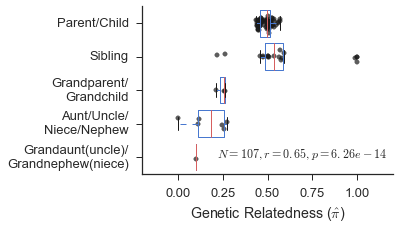

In [9]:
sns.set(style="ticks", color_codes=True, font_scale=1.3, palette="muted")

plt.figure(figsize=(4.5,3))
data = list()
names = list()
pos = 1
for rel in relative_options:
    if rel in ('Parent', 'Grandchild', 'Nephew/Niece', 'Grandnephew/Grandniece'):
        continue
    
    rs = [v[1] for v in rels[rel].values()]
    if len(rs) < 1:
        continue
    
    data.append( rs )
    #names.append( "(%.2f) %s" % (rel2dna[rel], rel if not rel.startswith('First') else '1st Cousin Once Rem') )
    name = rel
    if rel == 'Child':
        name = 'Parent/Child'
    if rel == 'Grandparent':
        name = 'Grandparent/\nGrandchild'
    if rel == 'Aunt/Uncle':
        name = 'Aunt/Uncle/\nNiece/Nephew'
    if rel == 'Grandaunt/Granduncle':
        name = 'Grandaunt(uncle)/\nGrandnephew(niece)'
    
    names.append( name )
    jitter = numpy.random.normal(0, .1, size=(len(rs),))
    
    plt.scatter(numpy.array(rs), numpy.array([pos]*len(rs))+jitter, color='k', alpha=0.7)
    pos += 1

plt.boxplot(data, widths=0.8, vert=False)

r, pval = stats.pearsonr(preds, sims)
plt.text(0.22, len(data), r"$N=%d, r=%.2f, p=%.2e$" % (len(sims), r, pval), fontsize=12)

ymin, ymax = plt.ylim()
plt.ylim(ymax, ymin)

plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks(range(1,len(names)+1), names)
plt.xlabel(r"Genetic Relatedness ($\hat{\pi}$)")
sns.despine(trim=False)
plt.savefig('../results/wicerigm_genotypes_compare.pdf')
# plt.tight_layout()

In [10]:
print stats.pearsonr(preds, sims)
print stats.linregress(preds, sims).rvalue**2

(0.64528652904421879, 6.2560629467620457e-14)
0.416394704566
